In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange

In [2]:
V_ap = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy")
V_na = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy")[:,:50000].flatten()
V_nona = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy")[:,:50000].flatten()

V_na_diff = np.zeros((V_ap.shape[0]))
V_nona_diff = np.zeros((V_ap.shape[0]))
V_na_diff[:-1] = np.diff(V_na)
V_nona_diff[:-1] = np.diff(V_nona)

V_pred_nona_mean = np.mean(np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"))
V_pred_nona = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/hand/gru_s10_h20_extra_output.npz")["test"].flatten() + V_pred_nona_mean
V_pred_na = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_extra_output.npz")["test"].flatten()
V_pred = V_pred_na + V_pred_nona

V_pred_whole_mean = np.mean(np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"))
V_pred_whole = np.load("/media/hdd01/sklee/CA1_clust4-60/whole/gru_s10_h20_extra_output.npz")["test"].flatten() + V_pred_whole_mean

V_pred_diff = np.zeros((V_pred.shape[0]))
V_pred_diff[:-1] = np.diff(V_pred)
V_pred_whole_diff = np.zeros((V_pred_whole.shape[0]))
V_pred_whole_diff[:-1] = np.diff(V_pred_whole)
V_pred_nona_diff = np.zeros((V_pred_nona.shape[0]))
V_pred_nona_diff[:-1] = np.diff(V_pred_nona)

train_trial_no = 500

In [3]:
print(np.min(V_pred_whole), np.max(V_pred_whole))
print(np.min(V_pred_whole_diff), np.max(V_pred_whole_diff))

print(np.min(V_pred), np.max(V_pred_whole))
print(np.min(V_pred_diff), np.max(V_pred_diff))

-68.88073255285688 -56.83449269995161
-0.909349799156189 2.579570949077606
-68.60308776282744 -56.83449269995161
-1.6805839238222688 1.8810050189495087


In [4]:
raw_times = np.where(V_ap >= 3)[0]
spk_times = []

for i in range(raw_times.shape[0]):
    if i == 0:
        spk_times.append(raw_times[i])
    else:
        if raw_times[i-1] != raw_times[i] - 1:
            spk_times.append(raw_times[i])
            
spk_times = np.asarray(spk_times)
print(spk_times.shape[0])

spk = np.zeros((V_ap.shape[0]))
spk[spk_times] = 1

#spk = spk[-20*50000:]
test_spk = spk[-20*50000:]
spk = spk[:train_trial_no*50000]

print(np.sum(spk))

9122
4532.0


In [5]:
V_ap = V_ap[:train_trial_no*50000]
V_na = V_na[:train_trial_no*50000]
V_nona = V_nona[:train_trial_no*50000]
V_na_diff = V_na_diff[:train_trial_no*50000]
V_nona_diff = V_nona_diff[:train_trial_no*50000]
V_pred = V_pred[:train_trial_no*50000]
V_pred_whole = V_pred_whole[:train_trial_no*50000]
V_pred_diff = V_pred_diff[:train_trial_no*50000]
V_pred_whole_diff = V_pred_whole_diff[:train_trial_no*50000]
V_pred_nona = V_pred_nona[:train_trial_no*50000]
V_pred_nona_diff = V_pred_nona_diff[:train_trial_no*50000]

In [6]:
window = 5

V = V_na
V_diff = V_na_diff
V_pad = np.zeros((V.shape[0] + window-1))
#V_diff_pad = np.zeros((V_diff.shape[0] + window-1))
V_pad[-V.shape[0]:] = V
#V_diff_pad[-V_diff.shape[0]:] = V_diff
spk_pad = np.zeros((spk.shape[0] + window-1))
spk_pad[-spk.shape[0]:] = spk

V_wind = np.zeros((V.shape[0]))
spk_wind = np.zeros((spk.shape[0]))
for i in tnrange(V.shape[0]):
    V_wind[i] = np.max(V_pad[i:i+window])
    if np.sum(spk_pad[i:i+window]) > 0:
        spk_wind[i] = 1

<ipython-input-6-7b752f7c7551>:14: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(V.shape[0]):


  0%|          | 0/25000000 [00:00<?, ?it/s]

In [7]:
diff_min = -1
diff_max = 1
val_max = -56
val_min = -63
interval = 0.1

diff_bins = np.arange(diff_min, diff_max+0.01, interval)
val_bins = np.arange(val_min, val_max+0.01, interval)
spk_2d_probs = np.empty((val_bins.shape[0]-1, diff_bins.shape[0]-1))

counts_2d = np.empty((val_bins.shape[0]-1, diff_bins.shape[0]-1))

for i in tnrange(val_bins.shape[0]-1):
    for j in range(diff_bins.shape[0]-1):
        idx = np.where((V_wind>=val_bins[i]) & (V_wind<val_bins[i+1]) & (V_diff>=diff_bins[j]) & (V_diff<diff_bins[j+1]))[0]
        yes_count = np.sum(spk_wind[idx])
        total_count = idx.shape[0]
        
        if total_count ==0:
            spk_2d_probs[i,j] = 0
            counts_2d[i,j] = 1
        else:
            spk_2d_probs[i,j] = yes_count / total_count
            counts_2d[i,j] = total_count

<ipython-input-7-15edc2f28f62>:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(val_bins.shape[0]-1):


  0%|          | 0/70 [00:00<?, ?it/s]

In [8]:
bins = np.arange(val_min, val_max+0.01, interval)
spk_probs = np.empty((bins.shape[0]-1))
counts = np.empty((bins.shape[0]-1))

for i in tnrange(bins.shape[0]-1):
    idx = np.where((V_wind >= bins[i]) & (V_wind < bins[i+1]))[0]
    yes_count = np.sum(spk_wind[idx])
    total_count = idx.shape[0]
    spk_probs[i] = yes_count / total_count
    counts[i] = total_count

<ipython-input-8-85f6b58eca11>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(bins.shape[0]-1):


  0%|          | 0/70 [00:00<?, ?it/s]

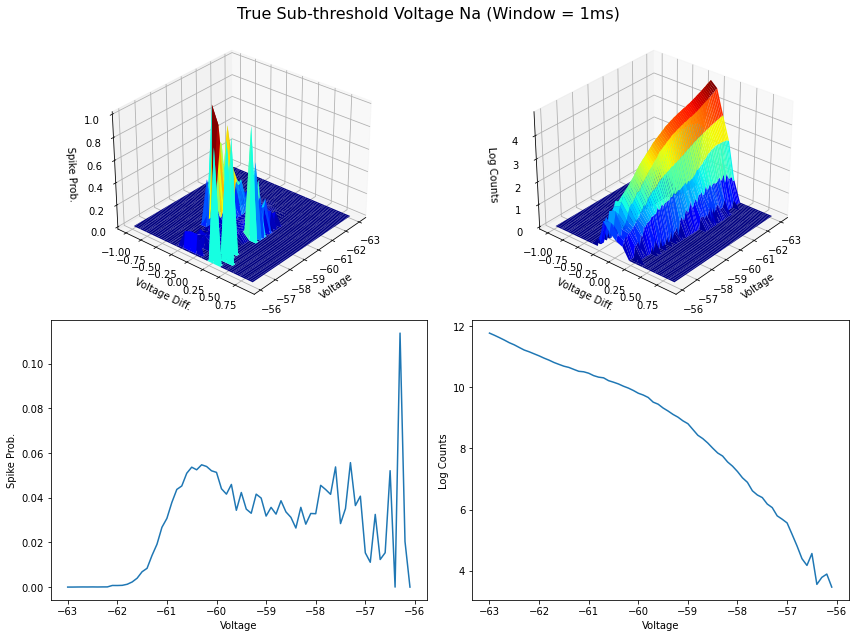

In [10]:
fig = plt.figure(figsize=(12,9))

ax1 = fig.add_subplot(2,2,1, projection='3d')
X, Y = np.meshgrid(val_bins[:-1], diff_bins[:-1])
probs1 = ax1.plot_surface(X, Y, spk_2d_probs.T, rstride=1, cstride=1,
                cmap='jet', edgecolor='none')
ax1.set_xlabel('Voltage')
ax1.set_ylabel('Voltage Diff.')
ax1.set_zlabel('Spike Prob.')
ax1.view_init(30, 40)

ax2 = fig.add_subplot(2,2,2, projection='3d')
probs1 = ax2.plot_surface(X, Y, np.log10(counts_2d.T), rstride=1, cstride=1,
                cmap='jet', edgecolor='none')
ax2.set_xlabel('Voltage')
ax2.set_ylabel('Voltage Diff.')
ax2.set_zlabel('Log Counts')
ax2.view_init(30, 40)

ax5 = fig.add_subplot(2,2,3)
ax6 = fig.add_subplot(2,2,4)
ax5.plot(bins[:-1], spk_probs)
ax6.plot(bins[:-1], np.log(counts))
ax5.set_xlabel("Voltage")
ax5.set_ylabel("Spike Prob.")
ax6.set_ylabel("Log Counts")
ax6.set_xlabel("Voltage")

plt.suptitle("True Sub-threshold Voltage Na (Window = 1ms)", fontsize=16)
fig.tight_layout()

plt.show()

#fig.savefig("/home/sklee/dendrite/AP_emp_PredNoNaWind.pdf", bbox_inches="tight", transparent=True)

In [16]:
test_V_na = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy")[:,:50000].flatten()[-20*50000:]
test_V_na_diff = np.zeros((test_V_na.shape[0]))
test_V_na_diff[:-1] = np.diff(test_V_na)

test_S_na = np.zeros((test_V_na.shape[0]))

for i in tnrange(val_bins.shape[0]-1):
    for j in range(diff_bins.shape[0]-1):
        test_idx = np.where((test_V_na>=val_bins[i]) & (test_V_na<val_bins[i+1]) & (test_V_na_diff>=diff_bins[j]) & (test_V_na_diff<diff_bins[j+1]))[0]
        #prob = spk_2d_probs[i,j]
        #test_spk_prob = np.ones((test_idx.shape[0])) * prob
        spk_sample = np.random.binomial(n=1, p=spk_2d_probs[i,j], size=test_idx.shape[0])
        test_S_na[test_idx] = spk_sample
        
        
    

<ipython-input-16-2822e93d6482>:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(val_bins.shape[0]-1):


  0%|          | 0/70 [00:00<?, ?it/s]

(0.9, 1.1)

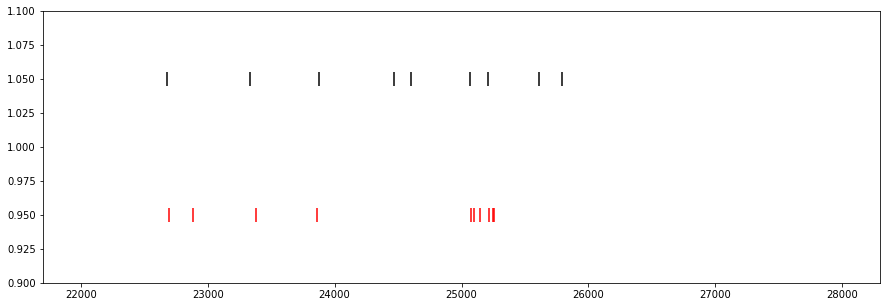

In [18]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(50000)[22000:28000], test_S_na[-50000:][22000:28000]*0.95, s=200, marker="|", color="red")
plt.scatter(np.arange(50000)[22000:28000], test_spk[-50000:][22000:28000]*1.05, s=200, marker="|", color="black")
plt.ylim(0.9,1.1)